# Vignette 1: Example usage of CITEgeist on Visium Data to examine cancer cell heterogeneity in a biopsy


Prior to using CITEgeist, it's important to note that Visium data reports different scales for the "spatial" coordinates as a result of different SpaceRanger settings. However, this is important for CITEgeist as CITEgeist relies on being able to accurately find rings of neighborhoods to deconvolute, hence we have developed a simple visualization function to find the correct radii for CITEgeist calculations based on your specific dataset

In [1]:
!which jupyter

/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/singlecell/bin/jupyter


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import importlib

sys.path.insert(0, os.path.abspath('..'))


In [4]:
path_to_visium_folder ="/bgfs/alee/LO_LAB/General/Lab_Data/20240510_Neil_SpatialSequencing_AgePatients/SpaceRanger_OUT/PVS19-12947/outs"

If you plan on running multiple samples in a joint analysis, we recommend testing multiple samples to find consistent radius parameters. As a rule of thumb, your neighborhoods must have as many or greater spots as the number of celltypes you aim to deconvolute. 

/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/singlecell/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


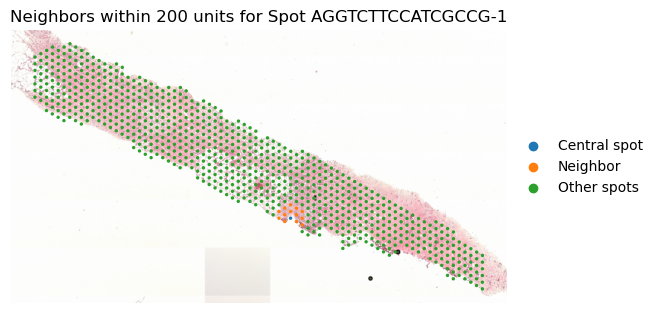

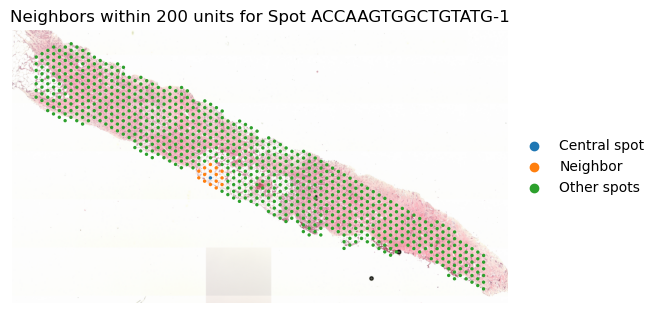

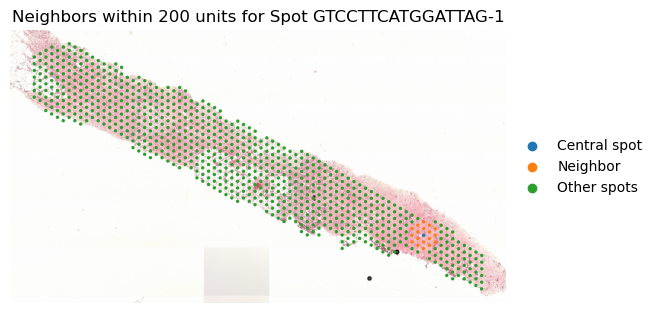

In [5]:
import scanpy as sc
from model.utils import plot_neighbors_with_fixed_radius

# Load dataset

adata = sc.read_visium(path_to_visium_folder, count_file='filtered_feature_bc_matrix.h5', load_images=True, gex_only=False)


# Test neighbor radius visualization
plot_neighbors_with_fixed_radius(adata, radius=200, num_spots=3)


We then need to load in the cell_profiles, there are the antibodies that are the markers for all of the cell types you are interested in the dataset. These do require human or manual curation, at this time, we show an example of what we list as Minor antibodies which we hope to use in future versions, but for now only Major antibodies are required. (Note the "-1" suffix for the antibodies, currently Scanpy is unable to differentiate Antibody Capture vs. Gene Expression variables when reading in the data, so Antibody Capture variables all end with a -1 if the gene is also included in the dataset)

In [7]:
cell_profiles = {
    "Cancer Cells": {
        "Major": ["EPCAM-1"],
        "Minor": ["SDC1-1",  "KRT5-1"]  # CD138 - possible cancer stem cell marker
    },
    "Macrophages": {
        "Major": ["CD68-1" ],  # General macrophage and M2-polarized macrophages
        "Minor": ["CD14-1"]  # Monocyte/macrophage lineage marker
    },
    "CD4 T Cells": {
        "Major": ["CD3E-1", "CD4-1"],  # General, Helper, and Cytotoxic T cells
    },
    "CD8 T Cells": {
        "Major": ["CD3E-1", "CD8A-1"],  # General, Helper, and Cytotoxic T cells
    },
    "B Cells": {
        "Major": ["MS4A1-1", "CD19-1"],  # General B cell markers and developmental marker
    },
    "Endothelial Cells": {
        "Major": ["PECAM1-1"],  # CD31 - endothelial cell marker
    },
    "Fibroblasts": {
        "Major": ["ACTA2-1"],  # α-SMA - myofibroblast marker, indicates activated stroma
    }
}


In [11]:
import scanpy as sc
import importlib
import model
importlib.reload(model)
from model import CitegeistModel  # Now directly import from the module
# Reload the model module if you're actively developing

# Initialize the model
model = CitegeistModel(sample_name="PVS19-12947", adata=adata, output_folder='output')

# Load cell profile dictionary
model.load_cell_profile_dict(cell_profiles)

# Preprocess and run models
# Split into gene expression and antibody capture datasets
model.split_adata()

model.filter_gex(row_cutoff=10, value_cutoff=1)

# Preprocess datasets
model.preprocess_gex()
model.preprocess_antibody()
print(model)

# Register Gurobi license
model.register_gurobi("/ihome/crc/install/gurobi/gurobi1102/linux64/lic/gurobi.lic")

# Run cell proportion model
model.run_cell_proportion_model()

# Plot cell proportions (Append cell proportions) 
model.append_proportions_to_adata()

# Run gene expression model (if needed)
# model.run_gex_model()
prop_adata = model.get_adata()

print(prop_adata)



CitegeistModel initialized successfully.
AnnData has been successfully split into 'gene_expression_adata' and 'antibody_capture_adata'.
Filtered gene expression data: 18085 → 6725 genes (row_cutoff=10, value_cutoff=1).
Gene expression data preprocessing completed: Normalized.
Antibody capture data preprocessing completed: Winsorized, CLR applied, no NaNs detected.
CitegeistModel Summary:
- Output Folder: output
- Main AnnData Loaded: Yes
- Gene Expression AnnData Loaded: Yes
- Antibody Capture AnnData Loaded: Yes
- Cell Profile Dictionary Loaded: Yes
- Gene Expression Preprocessed: Yes
- Antibody Capture Preprocessed: Yes
✅ Gurobi license file has been successfully configured.
 - GRB_LICENSE_FILE: /ihome/crc/install/gurobi/gurobi1102/linux64/lic/gurobi.lic

Iteration 1
Change in beta: 5.961473, Change in Y: 14.974116

Iteration 2
Change in beta: 0.000000, Change in Y: 0.000000
Convergence achieved.
Cell type proportions saved to 'output/PVS19-12947_cell_prop_results.csv'.
✅ Spot indice

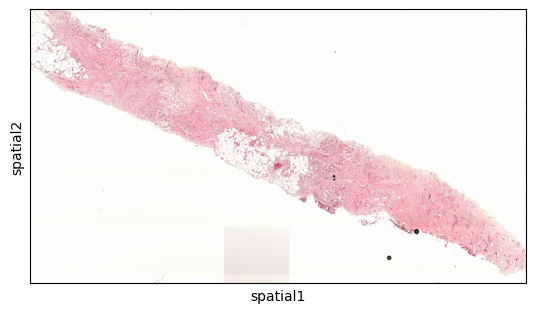

In [12]:
sc.pl.spatial(prop_adata)

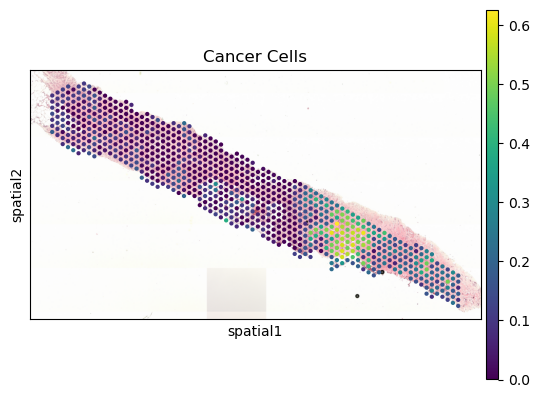

In [13]:
sc.pl.spatial(prop_adata, color = "Cancer Cells")

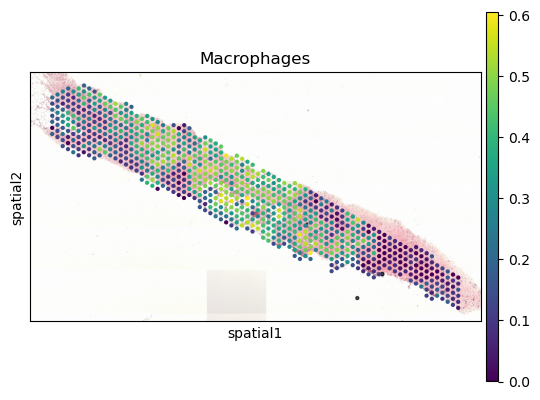

In [14]:
sc.pl.spatial(prop_adata, color = "Macrophages")

In [15]:
model.run_cell_expression_model(radius=200, alpha=0.5, lambda_reg_gex=0.001)

Deconvoluting Spots: 100%|██████████| 794/794 [12:09<00:00,  1.09it/s]


✅ Gene expression data saved to 'output/PVS19-12947_gene_expression.parquet'.


In [16]:
# Plot cell proportions (Append cell proportions) 
model.append_gex_to_adata()

prop_gex_adata = model.get_adata()

print(prop_gex_adata)



Parquet file loaded successfully.
Spot and CellType successfully split.
Added layers: Cancer_Cells_contribution, Cancer_Cells_genes (Shape: (794, 6725))
Added layers: Macrophages_contribution, Macrophages_genes (Shape: (794, 6725))
Added layers: CD4_T_Cells_contribution, CD4_T_Cells_genes (Shape: (794, 6725))
Added layers: CD8_T_Cells_contribution, CD8_T_Cells_genes (Shape: (794, 6725))
Added layers: B_Cells_contribution, B_Cells_genes (Shape: (794, 6725))
Added layers: Endothelial_Cells_contribution, Endothelial_Cells_genes (Shape: (794, 6725))
Added layers: Fibroblasts_contribution, Fibroblasts_genes (Shape: (794, 6725))
All layers added successfully.
Available layers: KeysView(Layers with keys: Cancer_Cells_contribution, Cancer_Cells_genes, Macrophages_contribution, Macrophages_genes, CD4_T_Cells_contribution, CD4_T_Cells_genes, CD8_T_Cells_contribution, CD8_T_Cells_genes, B_Cells_contribution, B_Cells_genes, Endothelial_Cells_contribution, Endothelial_Cells_genes, Fibroblasts_contr

In [ ]:
sc.pl.spatial(prop_gex_adata, color = "ESR1")

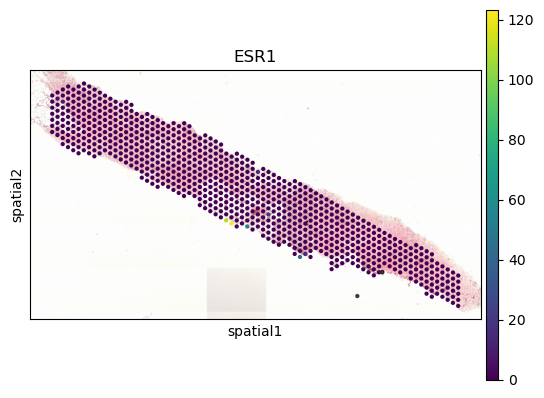

In [17]:
sc.pl.spatial(prop_gex_adata, layer = "Cancer_Cells_genes", color = "ESR1")

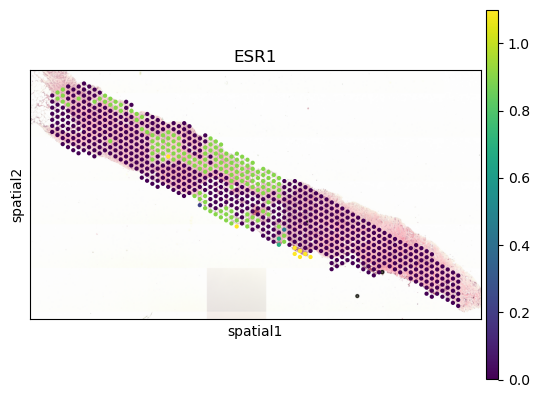

In [18]:
sc.pl.spatial(prop_gex_adata, layer = "Cancer_Cells_contribution", color = "ESR1")

# Analysis via CITEgeist Layers

For ease of use, our tools allow the parquet and proportion .csv files to be loaded into the CitegeistModel object without having to re-run the deconvolution. As long as the sample name is the same and the files are saved in the same output folder.

In [8]:
import scanpy as sc
import importlib
import model
importlib.reload(model)
from model import CitegeistModel  # Now directly import from the module
# Reload the model module if you're actively developing

# Initialize the model
model = CitegeistModel(sample_name="PVS19-12947", adata=adata, output_folder='output')

# Load cell profile dictionary
model.load_cell_profile_dict(cell_profiles)

# Preprocess and run models
# Split into gene expression and antibody capture datasets
model.split_adata()

model.filter_gex(row_cutoff=10, value_cutoff=1)

# Preprocess datasets
model.preprocess_gex()
model.preprocess_antibody()

# Plot cell proportions (Append cell proportions) 
model.append_proportions_to_adata()

# Plot cell proportions (Append cell proportions) 
model.append_gex_to_adata()

prop_gex_adata = model.get_adata()

print(prop_gex_adata)

CitegeistModel initialized successfully.
AnnData has been successfully split into 'gene_expression_adata' and 'antibody_capture_adata'.
Filtered gene expression data: 18085 → 6725 genes (row_cutoff=10, value_cutoff=1).
Gene expression data preprocessing completed: Normalized.
Antibody capture data preprocessing completed: Winsorized, CLR applied, no NaNs detected.
✅ Spot indices match between CSV and adata.obs.
✅ Cell type proportions have been appended to adata.obs.
Parquet file loaded successfully.
Spot and CellType successfully split.
Added layers: Cancer_Cells_contribution, Cancer_Cells_genes (Shape: (794, 6725))
Added layers: Macrophages_contribution, Macrophages_genes (Shape: (794, 6725))
Added layers: CD4_T_Cells_contribution, CD4_T_Cells_genes (Shape: (794, 6725))
Added layers: CD8_T_Cells_contribution, CD8_T_Cells_genes (Shape: (794, 6725))
Added layers: B_Cells_contribution, B_Cells_genes (Shape: (794, 6725))
Added layers: Endothelial_Cells_contribution, Endothelial_Cells_gen

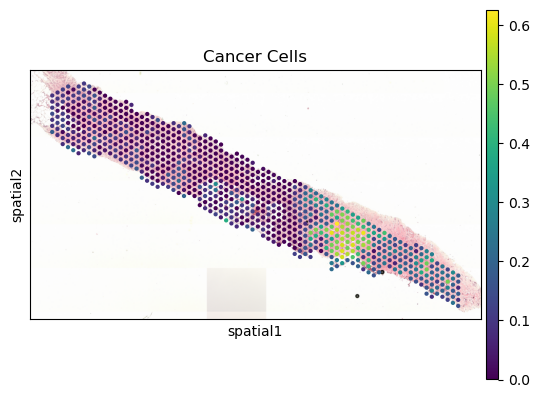

In [9]:
sc.pl.spatial(prop_gex_adata, color = "Cancer Cells")

Note, here we filter down the spots to spots with at least a 20% predicted cancer cell proportion. Otherwise the analysis will be affected by downstream noise. 

In [11]:
cancer_adata = prop_gex_adata[prop_gex_adata.obs["Cancer Cells"] > 0.2]

In [12]:
print(cancer_adata)

View of AnnData object with n_obs × n_vars = 154 × 6725
    obs: 'in_tissue', 'array_row', 'array_col', 'Cancer Cells', 'Macrophages', 'CD4 T Cells', 'CD8 T Cells', 'B Cells', 'Endothelial Cells', 'Fibroblasts'
    var: 'gene_ids', 'feature_types', 'genome', 'isotype_control', 'normalized', 'pattern', 'read', 'secondary_name', 'sequence'
    uns: 'spatial', 'highlight_colors'
    obsm: 'spatial'
    layers: 'Cancer_Cells_contribution', 'Cancer_Cells_genes', 'Macrophages_contribution', 'Macrophages_genes', 'CD4_T_Cells_contribution', 'CD4_T_Cells_genes', 'CD8_T_Cells_contribution', 'CD8_T_Cells_genes', 'B_Cells_contribution', 'B_Cells_genes', 'Endothelial_Cells_contribution', 'Endothelial_Cells_genes', 'Fibroblasts_contribution', 'Fibroblasts_genes'


In [13]:
# Normalize and scale the data if not already done
sc.pp.log1p(cancer_adata, layer = "Cancer_Cells_genes")


/bgfs/alee/LO_LAB/Personal/Alexander_Chang/alc376/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:405: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
sc.pp.pca(cancer_adata, layer = "Cancer_Cells_genes", svd_solver='arpack')


In [15]:
sc.pp.neighbors(cancer_adata, n_neighbors=10, n_pcs=50)


In [16]:
sc.tl.leiden(cancer_adata, resolution=0.5)


/tmp/ipykernel_31626/1076857834.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(cancer_adata, resolution=0.5)


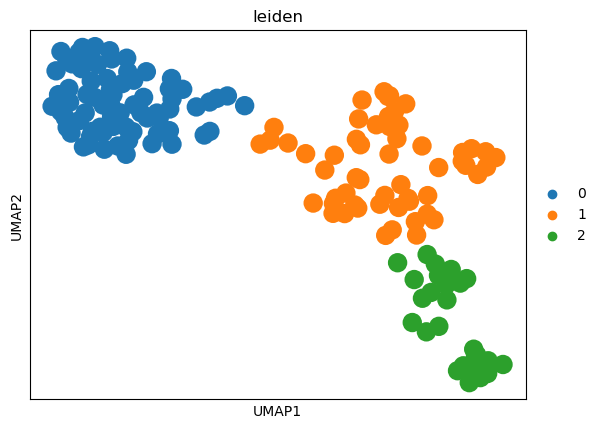

In [17]:
# Compute UMAP
sc.tl.umap(cancer_adata)
sc.pl.umap(cancer_adata, color=['leiden'])


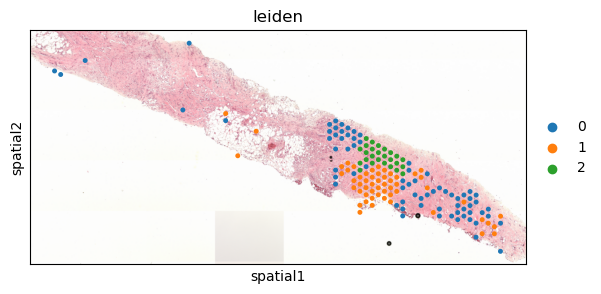

In [18]:
sc.pl.spatial(cancer_adata, color = "leiden")

In [19]:
# Add Cancer Leiden Back to the Spatial Object for plotting. 

sc.tl.rank_genes_groups(cancer_adata, layer = "Cancer_Cells_genes", groupby = "leiden")

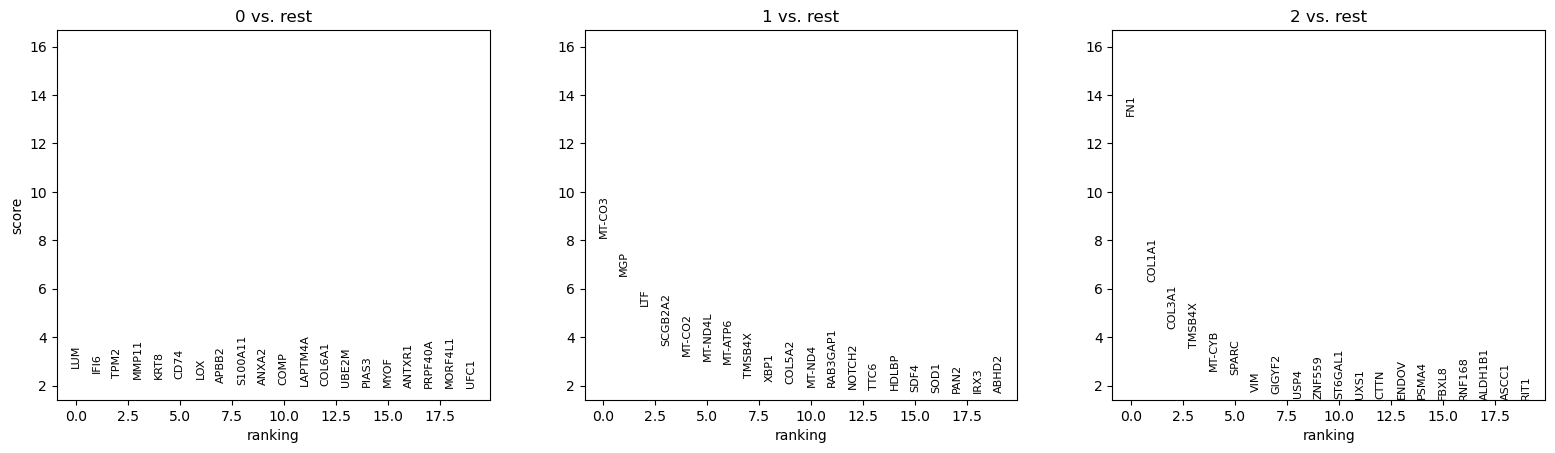

In [20]:
sc.pl.rank_genes_groups(cancer_adata)


Standard Scanpy analysis using GSEApy reveals three distinct cancer cell populations in this patient biopsy, revealing the ease by which CITEgeist layers can be used in standard existing analytical tools that use Scanpy layers. 

/tmp/ipykernel_31626/911541372.py:18: DeprecationWarning: processes is deprecated; use threads
  enr = gseapy.prerank(rnk=ranked_genes[group],
2024-12-27 16:37:31,720 [WARNING] Duplicated values found in preranked stats: 32.88% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_31626/911541372.py:18: DeprecationWarning: processes is deprecated; use threads
  enr = gseapy.prerank(rnk=ranked_genes[group],
2024-12-27 16:37:33,682 [WARNING] Duplicated values found in preranked stats: 33.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
/tmp/ipykernel_31626/911541372.py:18: DeprecationWarning: processes is deprecated; use threads
  enr = gseapy.prerank(rnk=ranked_genes[group],
2024-12-27 16:37:33,803 [WARNING] Duplicated values found in preranked stats: 33.28% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


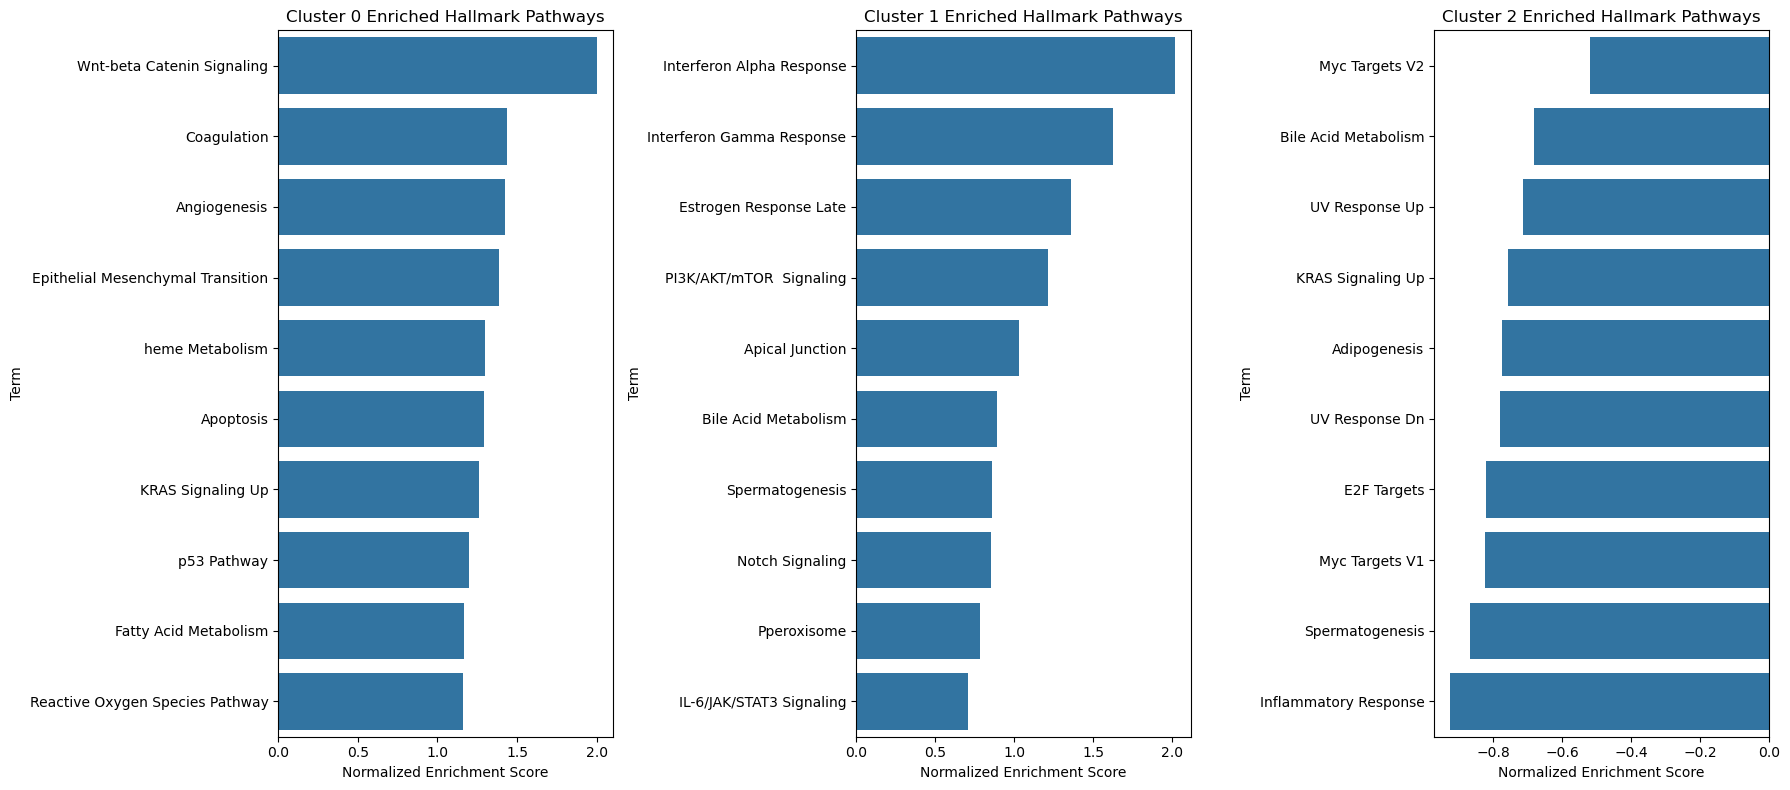

In [22]:
import gseapy
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Get ranked genes for each group
ranked_genes = {}
for group in cancer_adata.uns['rank_genes_groups']['names'].dtype.names:
    genes = cancer_adata.uns['rank_genes_groups']['names'][group]
    scores = cancer_adata.uns['rank_genes_groups']['scores'][group]
    # Create ranked list of genes with scores
    ranked_genes[group] = pd.Series(scores, index=genes)

# Run GSEA for each leiden cluster
enrichment_results = {}
for group in ranked_genes.keys():
    # Run pre-ranked GSEA
    enr = gseapy.prerank(rnk=ranked_genes[group],
                        gene_sets='MSigDB_Hallmark_2020',
                        processes=4,
                        permutation_num=100,
                        outdir=None,
                        seed=42,
                        no_plot=True)
    
    enrichment_results[group] = enr.res2d

# Plot top hallmark pathways for each cluster
fig, axes = plt.subplots(1, len(enrichment_results), figsize=(6*len(enrichment_results), 8))
if len(enrichment_results) == 1:
    axes = [axes]

for ax, (group, results) in zip(axes, enrichment_results.items()):
    # Get top pathways by NES score
    top_pathways = results.sort_values('NES', ascending=False).head(10)
    
    # Create barplot
    sns.barplot(data=top_pathways, y='Term', x='NES', ax=ax)
    ax.set_title(f'Cluster {group} Enriched Hallmark Pathways')
    ax.set_xlabel('Normalized Enrichment Score')
    
plt.tight_layout()
plt.show()
